In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
#from matplotlib.colors import LogNormZ
from matplotlib import rc
from numpy import inf
from matplotlib import gridspec

import os

rc('text', usetex=True)

import matplotlib as mpl
rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 

import matplotlib.pyplot as plt
import mplhep as hep
#hep.set_style(hep.style.CMS)
hep.set_style("CMS") 

/tmp/ipykernel_30582/3059572680.py:42: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("CMS")


In [2]:
mc = pd.read_pickle("/clusterfs/ml4hep/yxu2/unfolding_mc_inputs/Rapgap_nominal.pkl")

In [3]:
#boot_ensemble = np.load("bootstrap_rapgap_weights.npy")

In [42]:
bins = {}
dologx = [False,False,False,True]
dology = [True,False,True,True]

N_Bins = 10
q_max = 10.0
q_perp_bins = np.logspace(np.log10(1),np.log10(q_max),N_Bins+1)
q_perp_bins[0] = 0
#q_perp_bins = np.insert(q_perp_bins,0,0)
#q_perp_bins = [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  8., 10.]


bins[0] = q_perp_bins
#jet pt
bins[1] = np.logspace(np.log10(10),np.log10(100),7)


In [43]:
print(q_perp_bins)

[ 0.          1.25892541  1.58489319  1.99526231  2.51188643  3.16227766
  3.98107171  5.01187234  6.30957344  7.94328235 10.        ]


In [44]:
print(bins)

{0: array([ 0.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ]), 1: array([ 10.        ,  14.67799268,  21.5443469 ,  31.6227766 ,
        46.41588834,  68.12920691, 100.        ])}


In [45]:
#Data Unfolded From Rapgap
cuts_h1rpgp       = np.load('from_rapgap_cuts.npy')
jet_pT_h1rpgp     = np.load('from_rapgap_jet_pT.npy')
q_perp_h1rpgp     = np.load('from_rapgap_q_perp.npy')
asymm_phi_h1rpgp  = np.load('from_rapgap_asymm_angle.npy')
weights_h1rpgp    = np.load('from_rapgap_weights.npy')
mc_weights_h1rpgp = np.load("from_rapgap_mc_weights.npy")[cuts_h1rpgp]
nn_weights_h1rpgp = np.load("from_rapgap_nn_weights.npy")[cuts_h1rpgp]

In [46]:
symbol = {}
symbol['q_perp'] = '$q_\perp$ [GeV]'
symbol['jetpt'] = '$p_{T}^{jet}$ [GeV]'
symbol['dphi'] = '$\Delta\phi$ [rad]'
symbol['jeteta'] = '$\eta^{jet}$'
mylabels = ['q_perp','jetpt','dphi','qt']

In [47]:
theta0_G = np.stack((q_perp_h1rpgp,jet_pT_h1rpgp))

In [48]:
print(np.shape(theta0_G))

(2, 54120771)


In [49]:
boot_ensemble = np.load("bootstrap_rapgap_weights.npy")

In [50]:
unfolded_vals = {}

N_bootsraps = len(boot_ensemble)
N_bootsraps = 20
for bootstrap in range(N_bootsraps):
    if (bootstrap%10==0):
        print("on bootstrap:",bootstrap)
    for i in range(2):
        unfolded_vals[bootstrap,i],_ = np.histogram(theta0_G[i,:],bins=bins[i],weights=boot_ensemble[bootstrap],density=True)

on bootstrap: 0
on bootstrap: 10


/tmp/ipykernel_30582/801889245.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(mylabs)
/tmp/ipykernel_30582/801889245.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(mylabs)
/tmp/ipykernel_30582/801889245.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(mylabs)
/tmp/ipykernel_30582/801889245.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_yticklabels(mylabs)


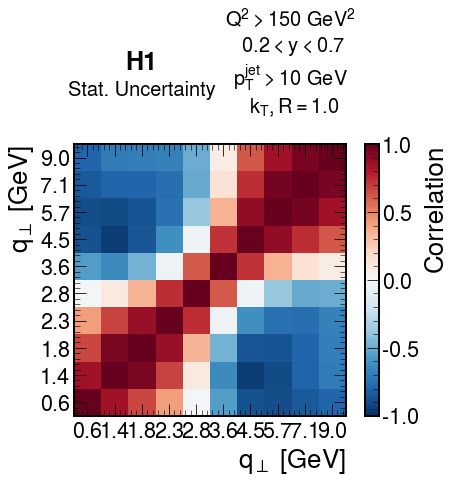

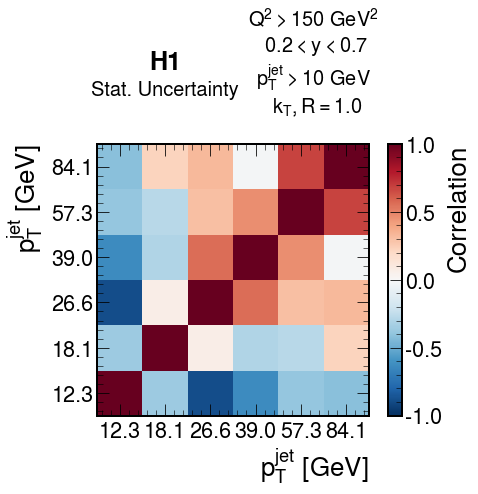

In [52]:
for jj in range(2):
                
    cov_mat = np.zeros([len(bins[jj])-1,len(bins[jj])-1])
    for i in range(len(bins[jj])-1):
            for j in range(len(bins[jj])-1):
                #Stat. uncert
                EX = np.mean(np.array([unfolded_vals[ii,jj] for ii in range(1,N_bootsraps)])[:,i]) #mean over the bootsraps. Array over the bootstraps of a given bin ei, 
                EY = np.mean(np.array([unfolded_vals[ii,jj] for ii in range(1,N_bootsraps)])[:,j]) #mean of bin j. 
                EXY = np.mean(np.array(np.array([unfolded_vals[ii,jj] for ii in range(1,N_bootsraps)])[:,i]*np.array([unfolded_vals[ii,jj] for ii in range(1,N_bootsraps)])[:,j]))
                cov_mat[i,j]+=EXY-EX*EY
            
    cov_mat = np.array(cov_mat)
    cor_mat = cov_mat.copy()
    for i in range(len(bins[jj])-1):
        for j in range(len(bins[jj])-1):
            cor_mat[i,j]=cov_mat[i,j]/(cov_mat[i,i]*cov_mat[j,j])**0.5

    fig = plt.figure(figsize=(7, 5)) 
    gs = gridspec.GridSpec(1, 1, height_ratios=[1]) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    ax0.minorticks_on()
    #plt.xticks(fontsize=20)
    #plt.yticks(fontsize=20)

    plt.imshow(cor_mat,vmin = -1,vmax = 1,origin='lower',cmap="RdBu_r")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel('Correlation')
    
    plt.text(0.25, 1.3,'H1',
                  horizontalalignment='center',
         verticalalignment='center',
         transform = ax0.transAxes, fontsize=25, fontweight='bold')
    plt.text(0.25, 1.2,'Stat. Uncertainty',
                  horizontalalignment='center',
         verticalalignment='center',
         transform = ax0.transAxes, fontsize=20)
    plt.text(0.8, 1.3,'$Q^{2}>$150 GeV$^{2}$ \n $0.2<y<0.7$ \n $p_{T}^{jet}>10$ GeV  \n $k_{T}, R=1.0$',
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax0.transAxes, fontsize=20)   

    plt.ylabel(symbol[mylabels[jj]])
    plt.xlabel(symbol[mylabels[jj]])
    mylabs = [""]
    if (j<2):
        for i in range(len(bins[jj])-1):
            mylabs+=["%0.0f" % (0.5*(bins[jj][i]+bins[jj][i+1]))]
    else:
        for i in range(len(bins[jj])-1):
            mylabs+=["%0.1f" % (0.5*(bins[jj][i]+bins[jj][i+1]))]
    ax0.set_xticklabels(mylabs)
    ax0.set_yticklabels(mylabs)
    ax0.xaxis.set_major_locator(plt.MaxNLocator(len(bins[jj])))
    ax0.yaxis.set_major_locator(plt.MaxNLocator(len(bins[jj])))
        
    #fig.savefig('figures/CorStatMat_%s.pdf'%mylabels[jj],bbox_inches='tight')
    fig.savefig("CovMat_lastTwoCombined_Bins_Obs"+str(jj)+".pdf")